In [1]:
#Importing necessary libraries
import os
import pandas as pd
import numpy as np
from copy import copy
import tensorflow as tf
import time
import spacy
import string
import matplotlib.pyplot as plt
from collections import Counter 
from collections import OrderedDict
from nltk.translate.bleu_score import sentence_bleu

In [2]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing.text import Tokenizer
from keras import layers
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [3]:
img_path = "/kaggle/input/flickr8kimagescaptions/flickr8k/images"

In [4]:
imgs = os.listdir(img_path)
len(imgs) # Number of images

8091

In [5]:
#Loading the captions
captions_path='/kaggle/input/cptupdt/captions_updated.txt'

In [6]:
file = open(captions_path,'r')
text = file.read()
file.close()

In [7]:
datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])

uni_filenames = np.unique(df_txt.filename.values)

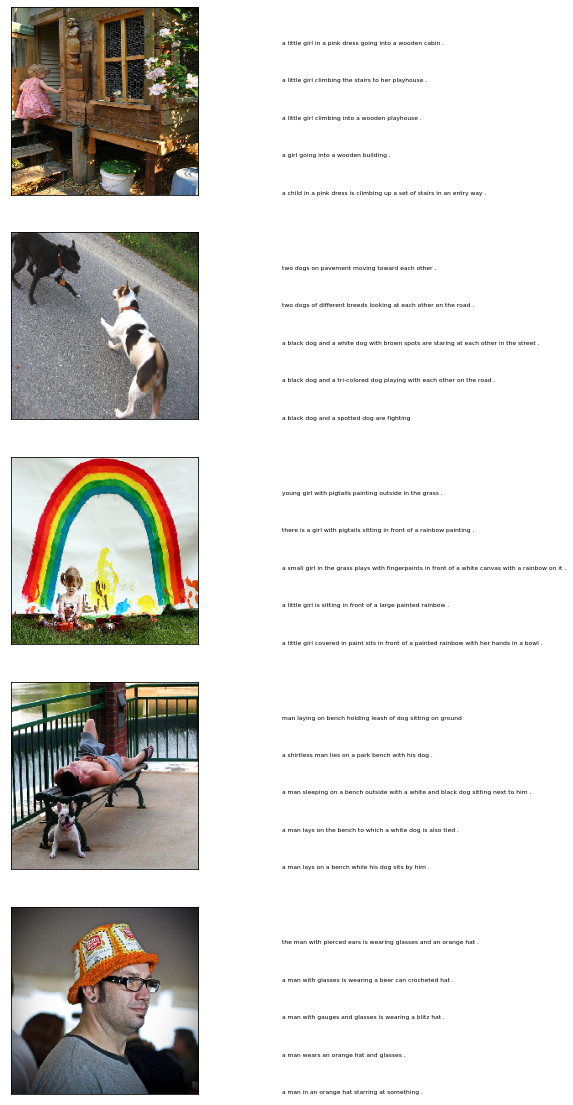

In [8]:
#First 5 images & their captions
npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:npic]:
    filename = img_path + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=6)
    count += 1
plt.show()

In [9]:
# Preparing the text
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":ct.keys(),"count":ct.values()})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(5)

Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975
3,the,18419
4,on,10744


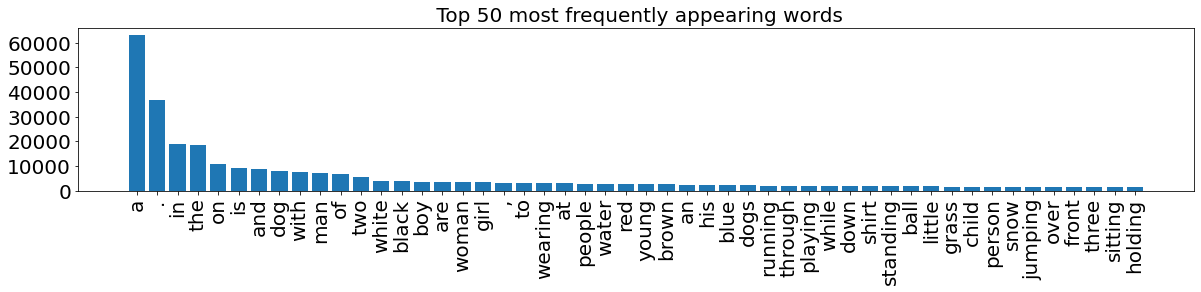

In [10]:
#Top 50 most frequently appearing words
topn = 50
def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title=" Top 50 most frequently appearing words")

In [11]:
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [12]:
#Cleaning the Text
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

Vocabulary Size: 8763


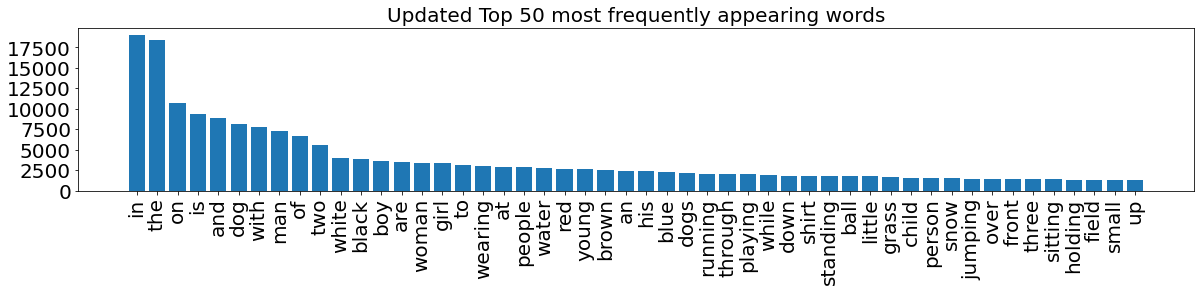

In [13]:
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],title="Updated Top 50 most frequently appearing words")

In [14]:
#Adding start & end sequence tokens
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [15]:
modelvgg = VGG19(include_top=True,weights='imagenet')
modelvgg.summary()

2023-01-29 10:14:12.313226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 10:14:12.314423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 10:14:12.315094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 10:14:12.315906: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
data = np.zeros((len(imgs),npix,npix,3))
for i,name in enumerate(imgs):
    #Load an image from file
    filename = img_path + '/' + name
    image = load_img(filename, target_size=target_size)
    #Convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    #Predict
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

2023-01-29 10:14:19.331433: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-29 10:14:19.823570: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [17]:
dimages, keepindex = [],[]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)

In [18]:
## the maximum number of words in dictionary
nb_words = 8000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


In [19]:
prop_test, prop_val = 0.1, 0.1 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [20]:
maxlen = np.max([len(text) for text in dtexts])

In [21]:
def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

# captions/images = 6473
 (65984, 30) (65984, 1000) (65984, 4476)
# captions/images = 809
 (8376, 30) (8376, 1000) (8376, 4476)


In [23]:
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = tf.keras.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

4476
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 64)       286464      input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 256)          328704      embedding[0][0]                  
_________________________________________________________________________________________

In [25]:
start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
end = time.time()
print("TIME".format((end - start )/60))

2023-01-29 10:22:10.871443: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1181377536 exceeds 10% of free system memory.
2023-01-29 10:22:12.237187: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1181377536 exceeds 10% of free system memory.


Epoch 1/5
1031/1031 - 39s - loss: 5.3071 - val_loss: 4.7367
Epoch 2/5
1031/1031 - 37s - loss: 4.4435 - val_loss: 4.4229
Epoch 3/5
1031/1031 - 35s - loss: 4.0474 - val_loss: 4.3226
Epoch 4/5
1031/1031 - 35s - loss: 3.7585 - val_loss: 4.2846
Epoch 5/5
1031/1031 - 35s - loss: 3.5207 - val_loss: 4.2904
TIME


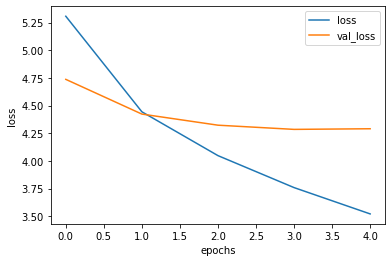

In [26]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

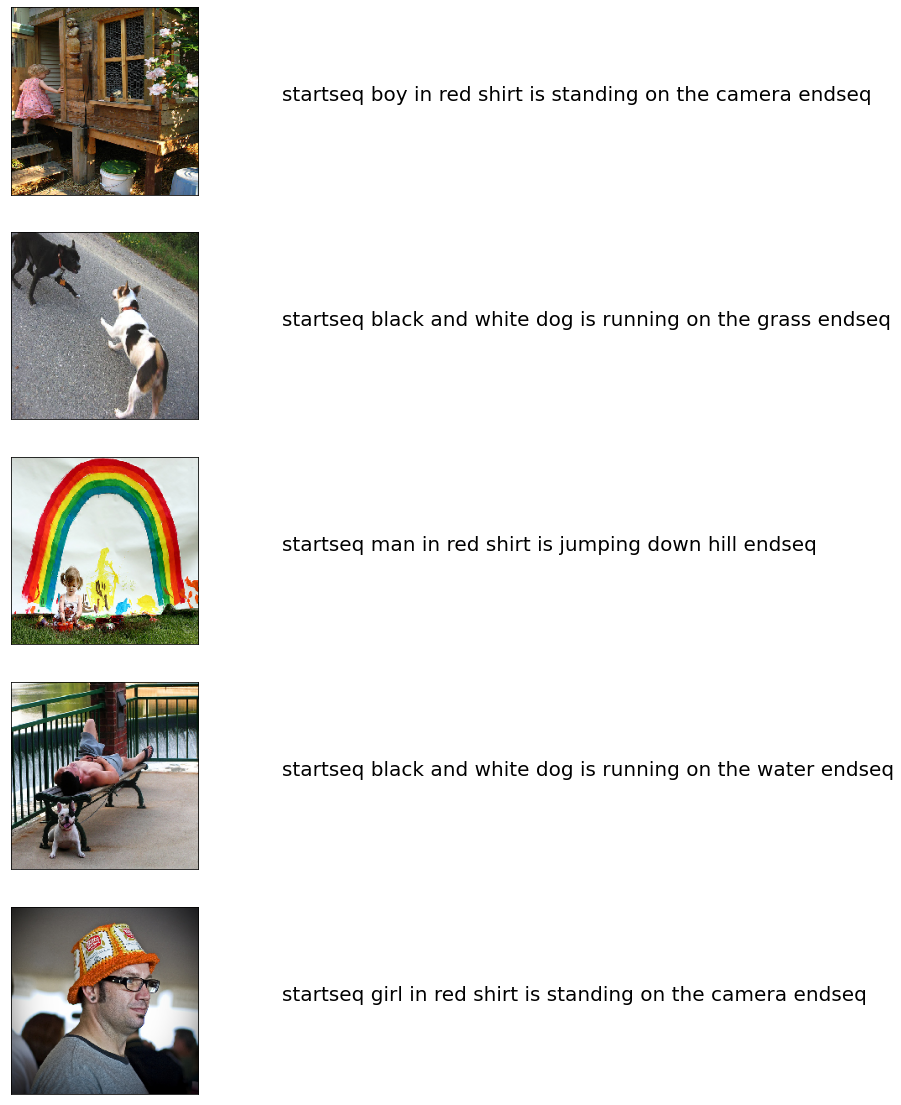

In [27]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    in_text = 'startseq'
    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = img_path + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

In [28]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])

nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

  24.72% is done..
  49.44% is done..
  74.17% is done..
  98.89% is done..
Mean BLEU 0.011
